In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

/home/tuts/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
print(pd.__version__)
print(np.__version__)

1.1.1
1.16.4


In [4]:
plt.style.use('ggplot')

What where trying to predict? The task is to forecast the total amount of products sold in every shop for the test set. 

A example for the evaluation section in Kaggle indicates what we're trying to predict:
```
ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.
```
So our target show be number of items sold in a month (considering all shops that sells this item)

## Reading data

In [5]:
items = pd.read_csv('input/competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('input/competitive-data-science-predict-future-sales/sales_train.csv')
item_categories = pd.read_csv('input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('input/competitive-data-science-predict-future-sales/test.csv')

In [6]:
print("items: shape={}".format(items.shape))
print("sales_train: shape={}".format(sales_train.shape))
print("item_categories: shape={}".format(item_categories.shape))
print("shops: shape={}".format(shops.shape))
print("test: shape={}".format(test.shape))

items: shape=(22170, 3)
sales_train: shape=(2935849, 6)
item_categories: shape=(84, 2)
shops: shape=(60, 2)
test: shape=(214200, 3)


In [7]:
print("***** ITEMS *****")
print(items.head())
print("***** SALES *****")
print(sales_train.head())
print("***** ITEM CAT *****")
print(item_categories.head())
print("***** SHOPS *****")
print(shops.head())

***** ITEMS *****
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
***** SALES *****
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1

## Sanity check

In [8]:
sales_train.isnull().sum(axis=1).unique()

array([0])

In [9]:
sales_train.isnull().sum(axis=0).unique()

array([0])

In [10]:
len(sales_train[sales_train.duplicated()])

6

## Feature Engineering Pt 1

In [11]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_train['day'] = pd.DatetimeIndex(sales_train['date']).day
sales_train['month'] = pd.DatetimeIndex(sales_train['date']).month
sales_train['year'] = pd.DatetimeIndex(sales_train['date']).year

In [12]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013


In [13]:
sales_train['revenue'] = sales_train.item_price * sales_train.item_cnt_day

In [14]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,999.00
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1099.00


In [15]:
sales_train['date'].value_counts()

2013-12-28    9434
2013-12-29    9335
2014-12-30    9324
2013-12-30    9138
2014-12-31    8347
              ... 
2015-05-14    1174
2015-04-28    1154
2015-10-06    1152
2015-05-13    1128
2015-05-12    1123
Name: date, Length: 1034, dtype: int64

## Exploring the data

In [16]:
days_revenue = sales_train[['date', 'revenue']]
days_revenue = days_revenue.groupby(['date']).sum()

days_revenue.head()

,revenue
date,
2013-01-01,1362942.00
2013-01-02,6020512.03
2013-01-03,5436480.11
2013-01-04,4755664.00
2013-01-05,4587231.00


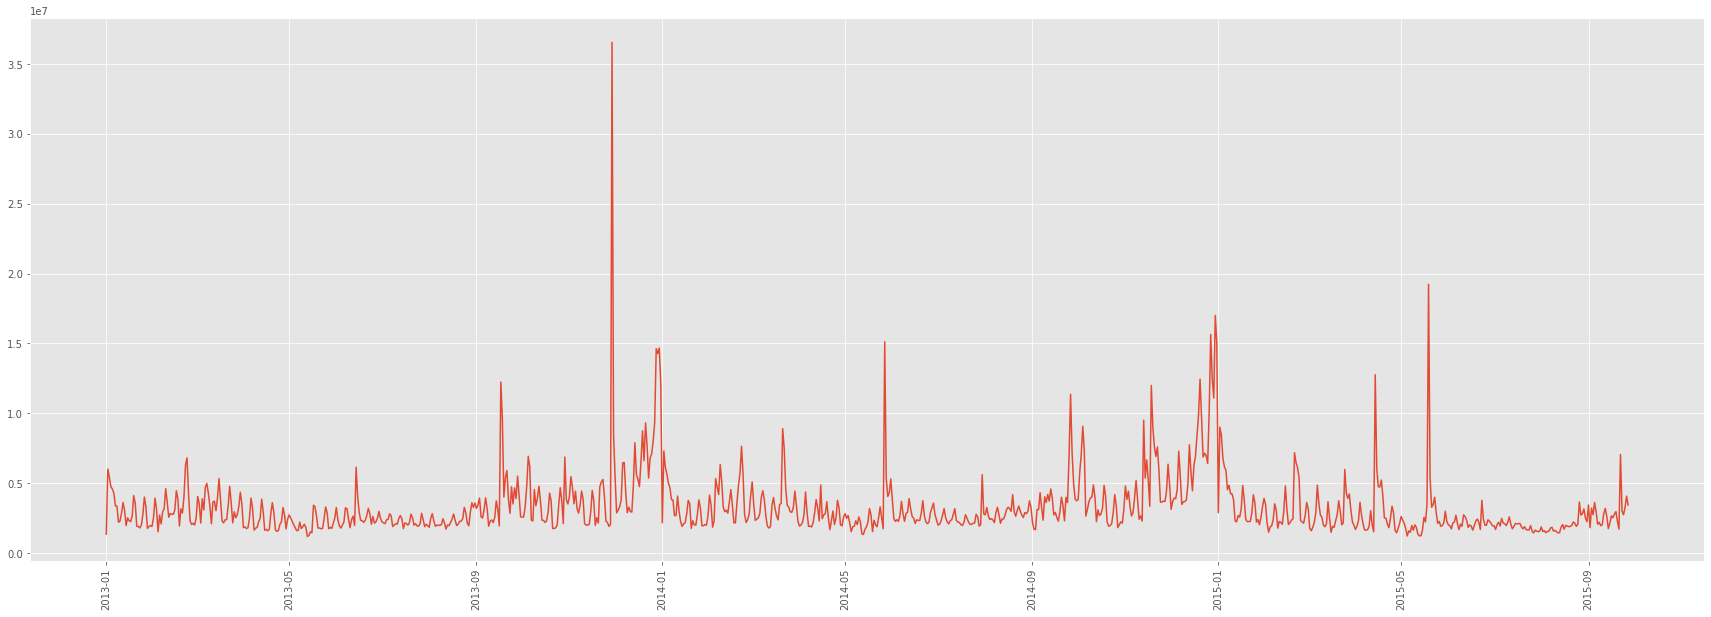

In [17]:
plt.figure(figsize=(30,10))
plt.plot(days_revenue[:1000].index, days_revenue[:1000].revenue)
plt.xticks(rotation=90)
plt.show()

In [18]:
sales_train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [19]:
summer = [6, 7, 8]
winter = [1, 2, 12]
fall = [9, 10, 11]
spring = [3, 4, 5]

sales_train['season'] = sales_train['month'].apply(lambda m: 'w' if m in winter else ('su' if m in summer else ('f' if m in fall else 'sp')))
sales_train.season.unique()

array(['w', 'sp', 'su', 'f'], dtype=object)

In [20]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue,season
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,999.00,w
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,899.00,w
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,-899.00,w
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1709.05,w
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1099.00,w


In [21]:
season_revenue = sales_train[['season', 'revenue']]
season_revenue = season_revenue.groupby(['season']).sum()

season_revenue.head()

,revenue
season,
f,9.215179e+08
sp,7.855077e+08
su,6.585123e+08
w,1.033388e+09


<BarContainer object of 4 artists>

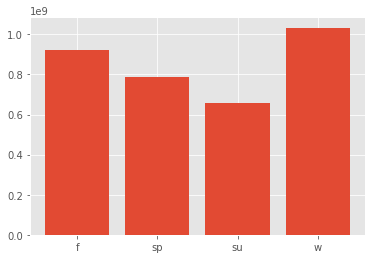

In [22]:
plt.bar(season_revenue.index, season_revenue.revenue)

Checking how much a given shop earned in the whole timeseries

In [23]:
shop_revenue = sales_train[['shop_id', 'revenue']]
shop_revenue = shop_revenue.groupby(['shop_id'], as_index=False).sum()

shop_revenue.sort_values(by=['revenue']).tail()

,shop_id,revenue
54,54,1.419397e+08
42,42,1.519170e+08
28,28,1.597463e+08
25,25,2.164806e+08
31,31,2.352170e+08


In [24]:
shop_revenue = shop_revenue.sort_values(by=['revenue'])

Check the shop that made the most revenue given the whole timeseries

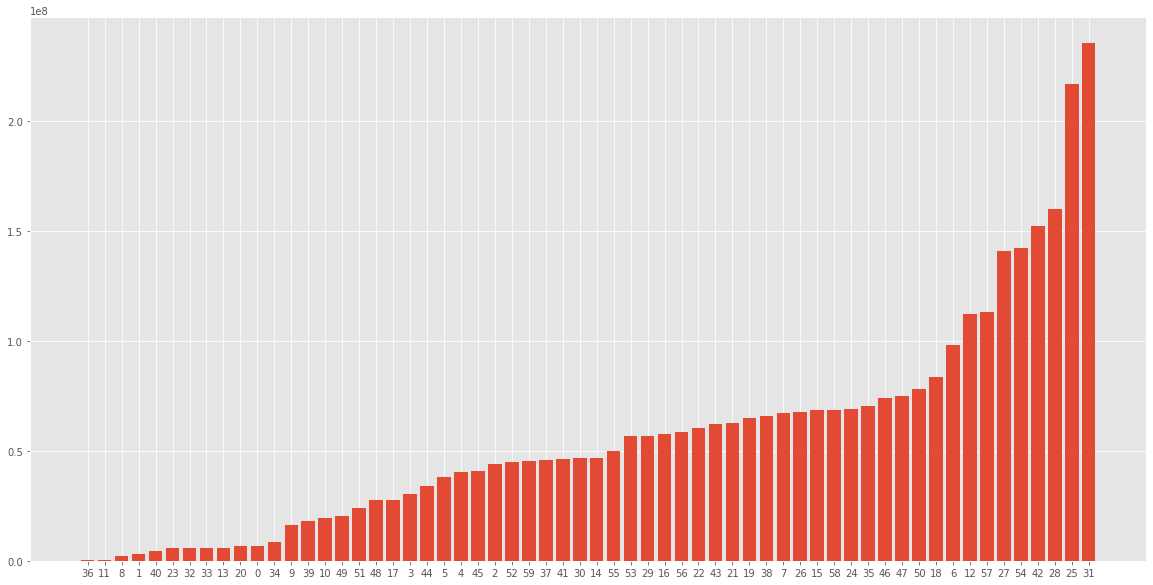

In [25]:

plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(shop_revenue))], shop_revenue.revenue)
plt.xticks([i for i in range(len(shop_revenue))], shop_revenue.shop_id)
plt.show()

<AxesSubplot:xlabel='item_price'>

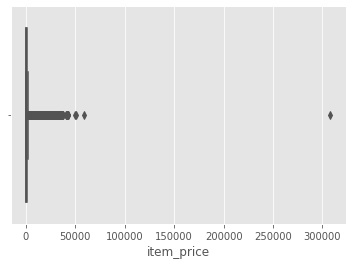

In [26]:
sns.boxplot(x=sales_train.item_price)

<AxesSubplot:xlabel='item_price'>

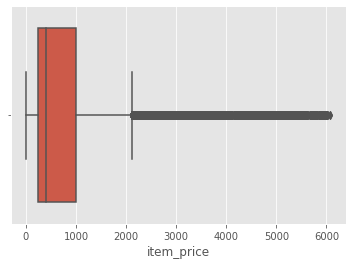

In [27]:
from scipy.stats import zscore

zscores = np.abs(zscore(sales_train.item_price))
mask = (zscores < 3)

sales_train = sales_train[mask]

sns.boxplot(x=sales_train.item_price)

In [28]:
sales_train.shape

(2907148, 11)

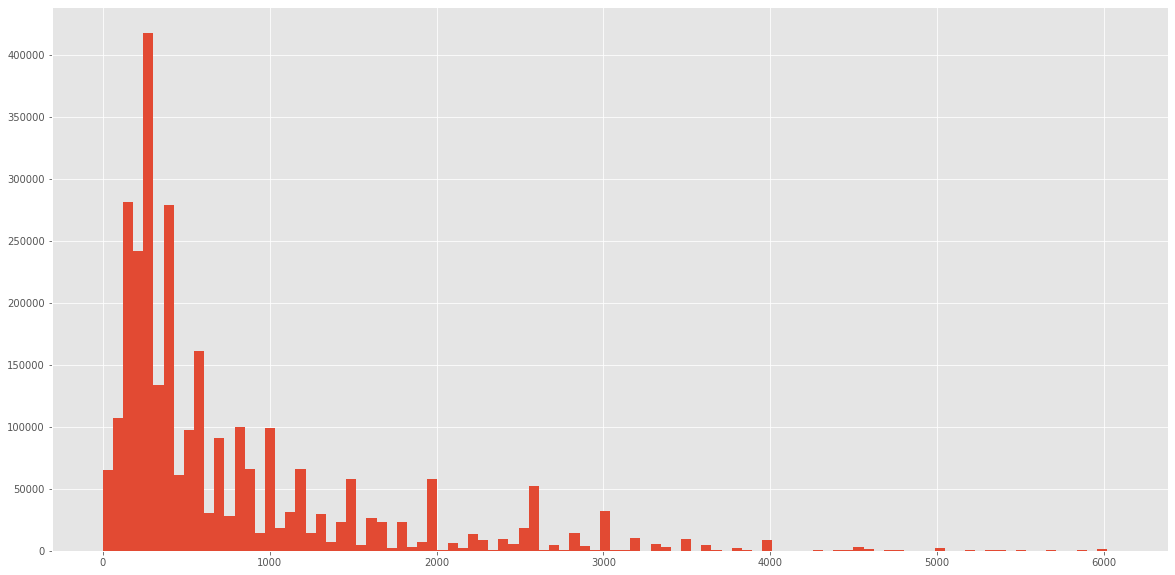

In [31]:
plt.figure(figsize=(20,10))
plt.hist(sales_train.item_price, bins=100, )
plt.show()

In [37]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [38]:
shop_item_sales = sales_train[['shop_id', 'item_id', 'revenue']]
shop_item_sales = shop_item_sales.groupby(['shop_id', 'item_id']).sum()

shop_item_sales.head()

revenue
shop_id item_id         
0       30        8215.0
        31        4774.0
        32        3536.0
        33        2082.0
        35        3705.0

In [39]:
shop_item_sales.shape

(419191, 1)

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [51]:
X = shop_item_sales.index
y = shop_item_sales.revenue

In [52]:
rf = RandomForestRegressor()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [53]:
rf.fit(X_train, y_train)

/home/tuts/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: setting an array element with a sequence.